In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import networkx as nx
from scipy.spatial.distance import cdist
import os

# Census & Travel Survey Generation

Here you can build **household census**, **census commuter** and **household travel survey data** for a fake city. We use these outputs for testing new activity sampling and synthesis methodologies.

**Outputs:**
- **Census Marginal Statistic** - aggregate household and population statistics by statistical zones
- **Census Commuter Survey** - work and education trip OD matrix
- **Household Travel Survey** - full and sampled household activity data

These outputs are based on a sequential generation of the following city features:

**Facilities:** Generate activity locations (including households) clustered around centres of density.

**Road Networks:** Generate a road network based on facility density.

**Road Transit Routes:** Generate road transit routes using the road network.

**Rail Transit Network and Routes:** Generate a rail network based on facility density.

**Statistical Zones:** Generate statistical zones based on facility density.

**Population:** Generate a population of agents, with consistent household attributes. The distribution of the population attributes is dependant on the above spatial features and some encoded underlying distributions.

**Plans:** Generate simple activity based plans for each agent, currently only supports simple tour based plans. The distribution of the plan attributes, such as activity choice and mode, is dependant on the agent, facility and network features.

In [2]:
from citychef import spatial
from citychef import graph
from citychef import household as hh
from citychef import person
from citychef import tree
from citychef import choice

In [3]:
# uncomment if you are making changes to core modules
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload

In [4]:
city_dir = "./census_survey_example"

In [5]:
if not os.path.exists(city_dir):
    os.mkdir(city_dir)
else:
    print("WARNING - potentially overwritting previous results")

### Facilities
First we generate the location of various facilities, including households where the populations will live and activity locations such work places, leisure, education, shopping and health facilities.

#### Method
1. define seed bounding box (KMs)
2. uniformly sample 'centres' within bounding box
3. poisson sample number of facilities of each type around each centre
4. gaussian sample locations of facilities around each centre

6 centres

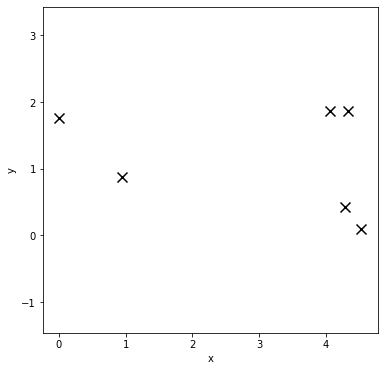

In [6]:
bbox = np.array([[0,0],[5,5]])  # min x, min y, max x, max y (KMs)
centres = spatial.Centres(bbox, density = 0.2)
centres

In [7]:
facilities = {
    'households': spatial.Clusters(centres, size=10000, sigma=1),
    'work': spatial.Clusters(centres, size=1000, sigma=1),
    'leisure': spatial.Clusters(centres, size=500, sigma=1),
    'education': spatial.Clusters(centres, size=100, sigma=1),
    'health': spatial.Clusters(centres, size=100, sigma=.5),
    'shopping': spatial.Clusters(centres, size=1000, sigma=.7),
}
bbox = spatial.collect_bbox(facilities) # adjust the bbox for max extends

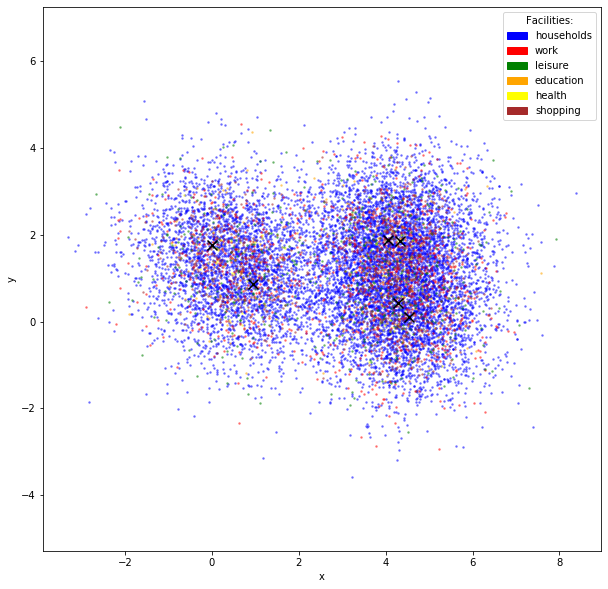

In [53]:
spatial.plot_facilities(facilities, centres=centres)

### Road Network

We build a road network for car travel. We use a quad tree to define the density of the network so that accessibility is likely better where household density is higher. The connectivity of the resulting networks is based on parent - child relationships within the quad tree. This results in poor connectivity between neighbouring quad grids if they are removed by several generations, ie their shared parent is distant.

Edges are assigned a distance, a freespeed (based on distance) and a freeflow traversal time.

#### Method

1. Build a grid tree with maximum household density of N.
2. Build a network of roads from the grid tree

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


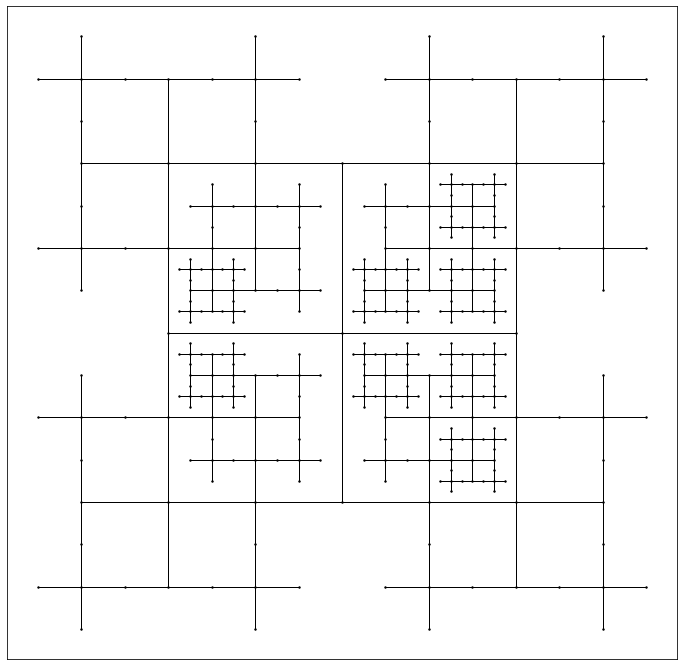

In [9]:
car_network = graph.TreeNetwork(bbox, facilities['households'], grid='regular', max_points=500)
car_network.plot()

In [10]:
fig.savefig(os.path.join(city_dir, 'road_network.png'))

### Bus Network

We build a bus network for public transit travel on the road network. A route generation algorithm attempts to build viable routes by making weighted random walks across the road network from seed locations.

The random walks are seeded based on a weighted sample from the road network vertices. Where the vertices are weighted by household density at each vertices. From each seed location the weighted random walk traverses the possible network based on weighted random choice of each possible step. Where weights are based on the household density of the possible choices, the straightness of the resulting graph and the number of times the edges have already been traversed by a route. Routes cannot repeat the previous edge so that the traversal ends at dead ends in the road network or when a maximum number of stops is reached.

Edges are assigned a distance, a freespeed (based on distance) and a freeflow traversal time as per the underlying road network. For simplicity, no consideration is made of a schedule or interchange times.

#### Method

1. Build an array of houshold density for each vertices of the road network graph
2. Sample number of required routes based on population and a poisson distribution
3. Generate route
4. Add generated routes that meet minimum requirements for stops and length
5. Combine routes to form total bus network graph

In [11]:
buses = graph.Transit(car_network, facilities['households'])
bus_routes = buses.build_routes(num_routes=20, max_length=30, min_length=10, straightness=2)

In [12]:
total_bus_graph = buses.graph

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


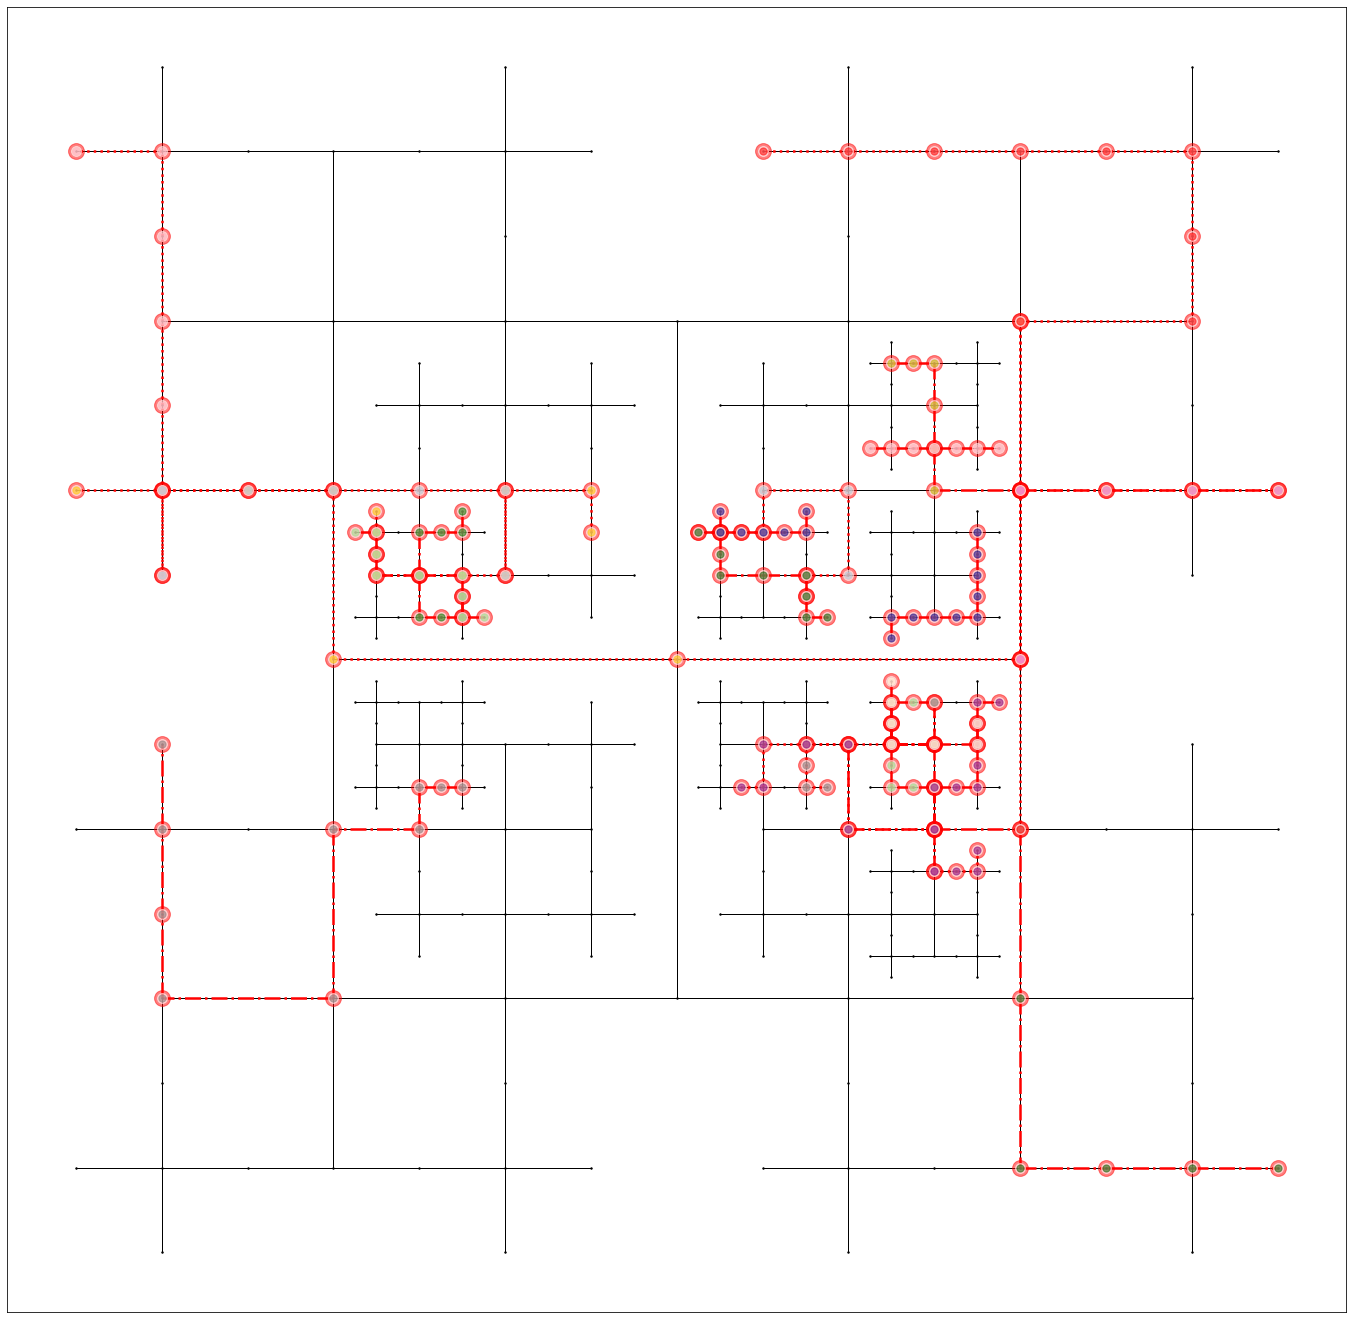

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
buses.plot(ax=ax)

In [14]:
fig.savefig(os.path.join(city_dir, 'bus_network.png'))

### Rail Network

We build a rail network for public transit travel not restricted by the road network. As per the bus network a route generation algorithm attempts to build viable routes by weighted random walks. Unlike the bus network we build a new graph for all potential rail connections. This graph connects all road network junctions (not dead ends) based on Delaunay triangulation.

The random walks are seeded and traverse as per the bus network.

Edges are assigned a distance, a speed (based on distance) and a resulting traversal time. For simplicity, no consideration is made of a schedule or interchange times.

#### Method

1. Build an array of houshold density for junction vertices of the road network graph
2. Sample number of required routes based on population and a poisson distribution
3. Generate routes
4. Add generated routes that meet minimum requirements for stops and length
5. Combine routes to form total rail network graph

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


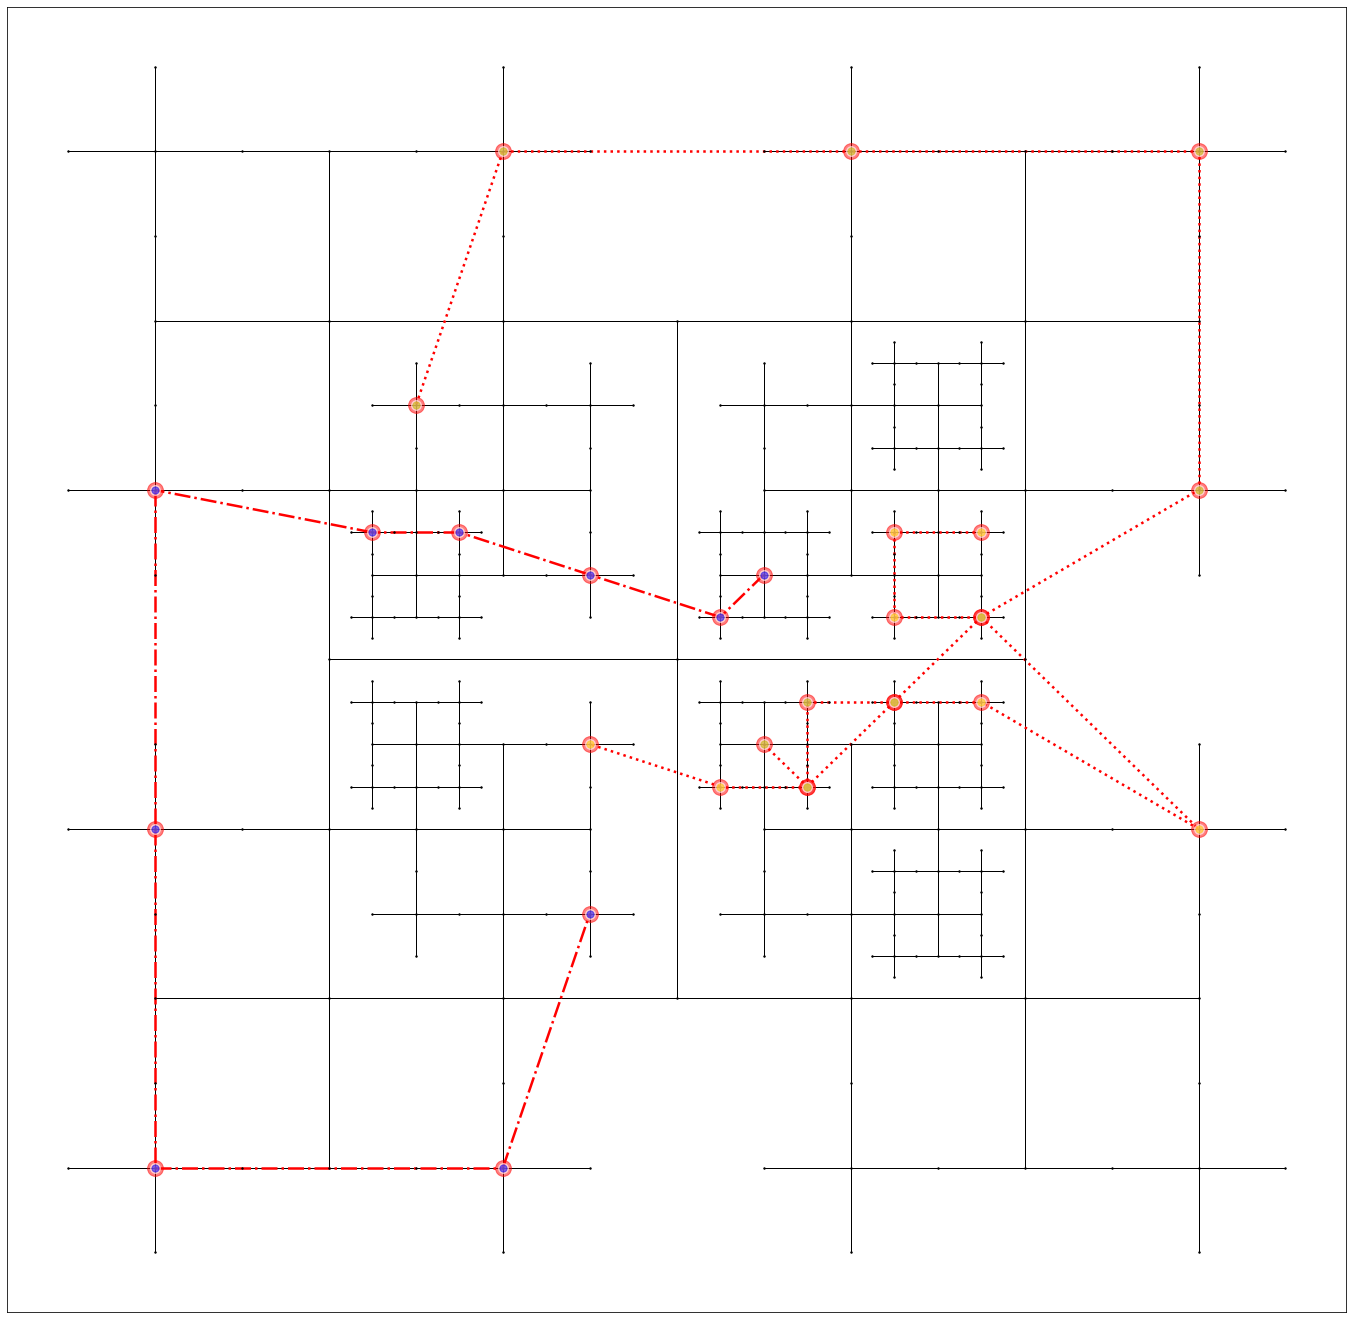

In [15]:
# first we extract potential locations for stations, we force stations to match vertices
# from the road ntwork, eg :
potential_stations = np.array([v['pos'] for k, v in car_network.g.nodes.items() if k[-6:] == 'centre'])
rail_network = graph.DelaunayNetwork(potential_stations)

trains = graph.Transit(rail_network, facilities['households'])
train_routes = trains.build_routes(num_routes=2, max_length=10, min_length=10, straightness=30)

fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
trains.plot(ax=ax)

In [16]:
total_train_graph = trains.graph

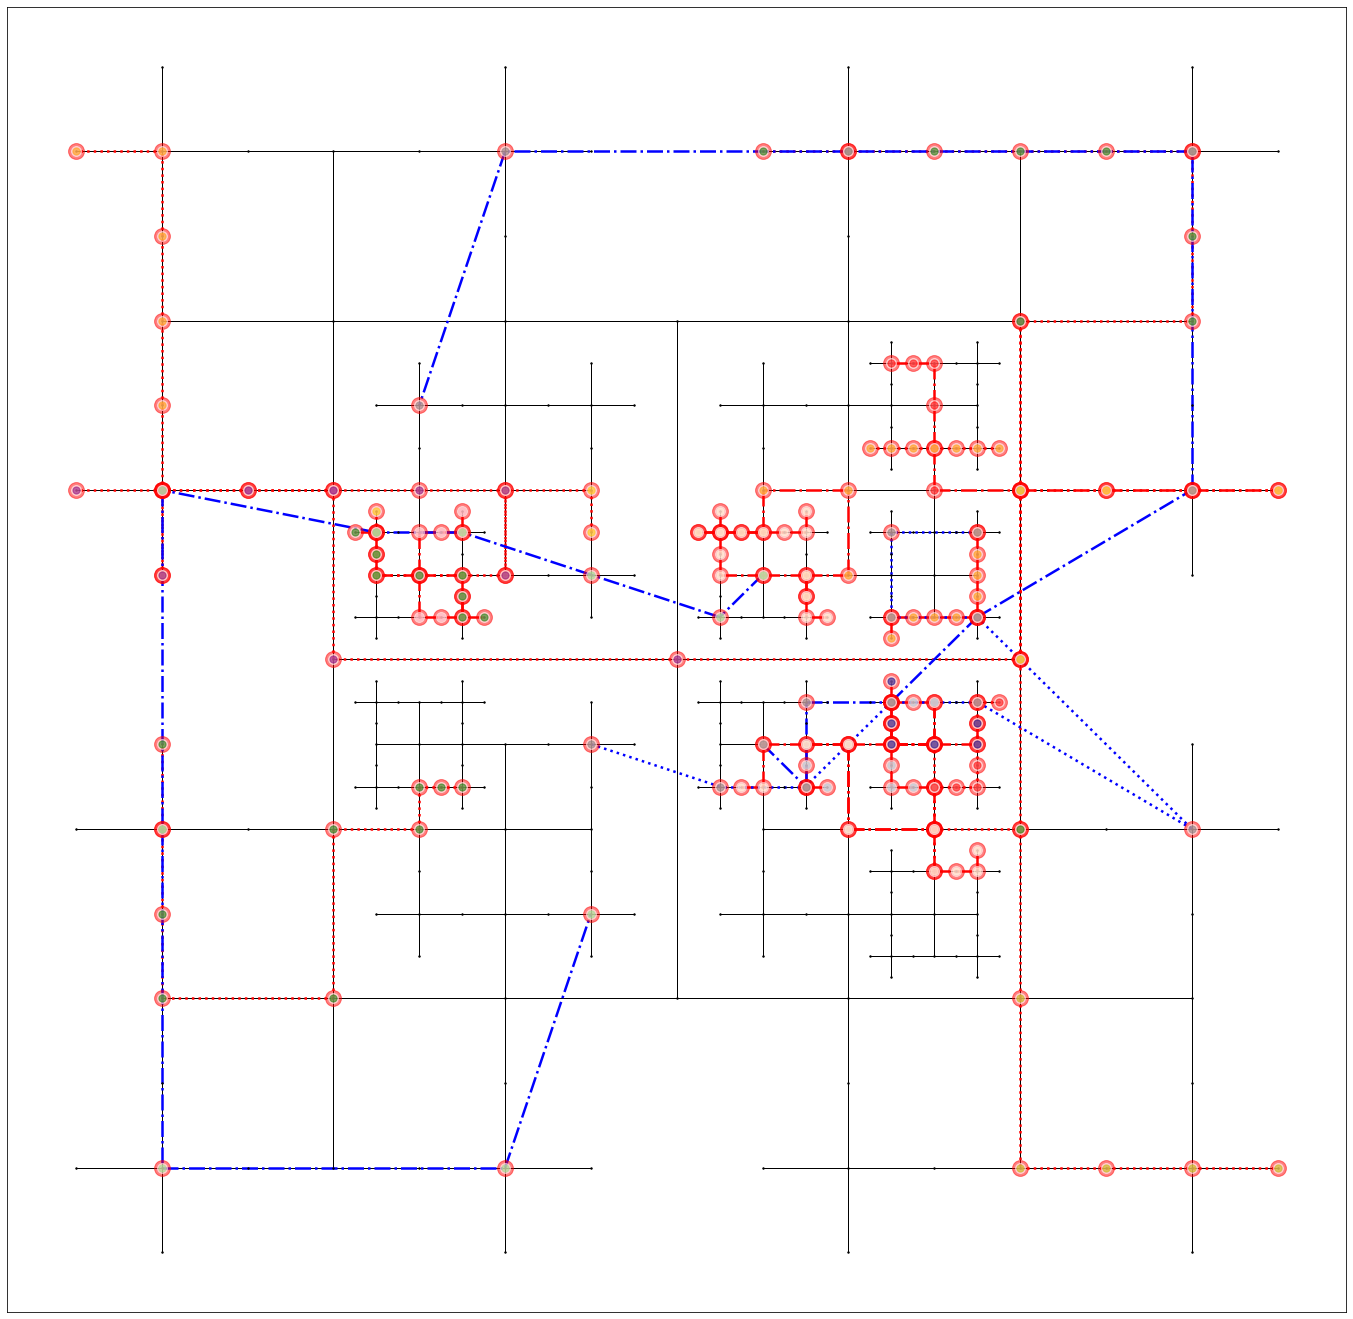

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
buses.plot(ax=ax)
trains.plot(ax=ax, line_colour='blue')

In [18]:
fig.savefig(os.path.join(city_dir, 'rail_network.png'))

### Infrastructure

We now have spatial and graph representations of our city facilities and infrastructure.

(-3.889549319948718, 8.954466830633757, -4.036165994492228, 5.9946857639321784)

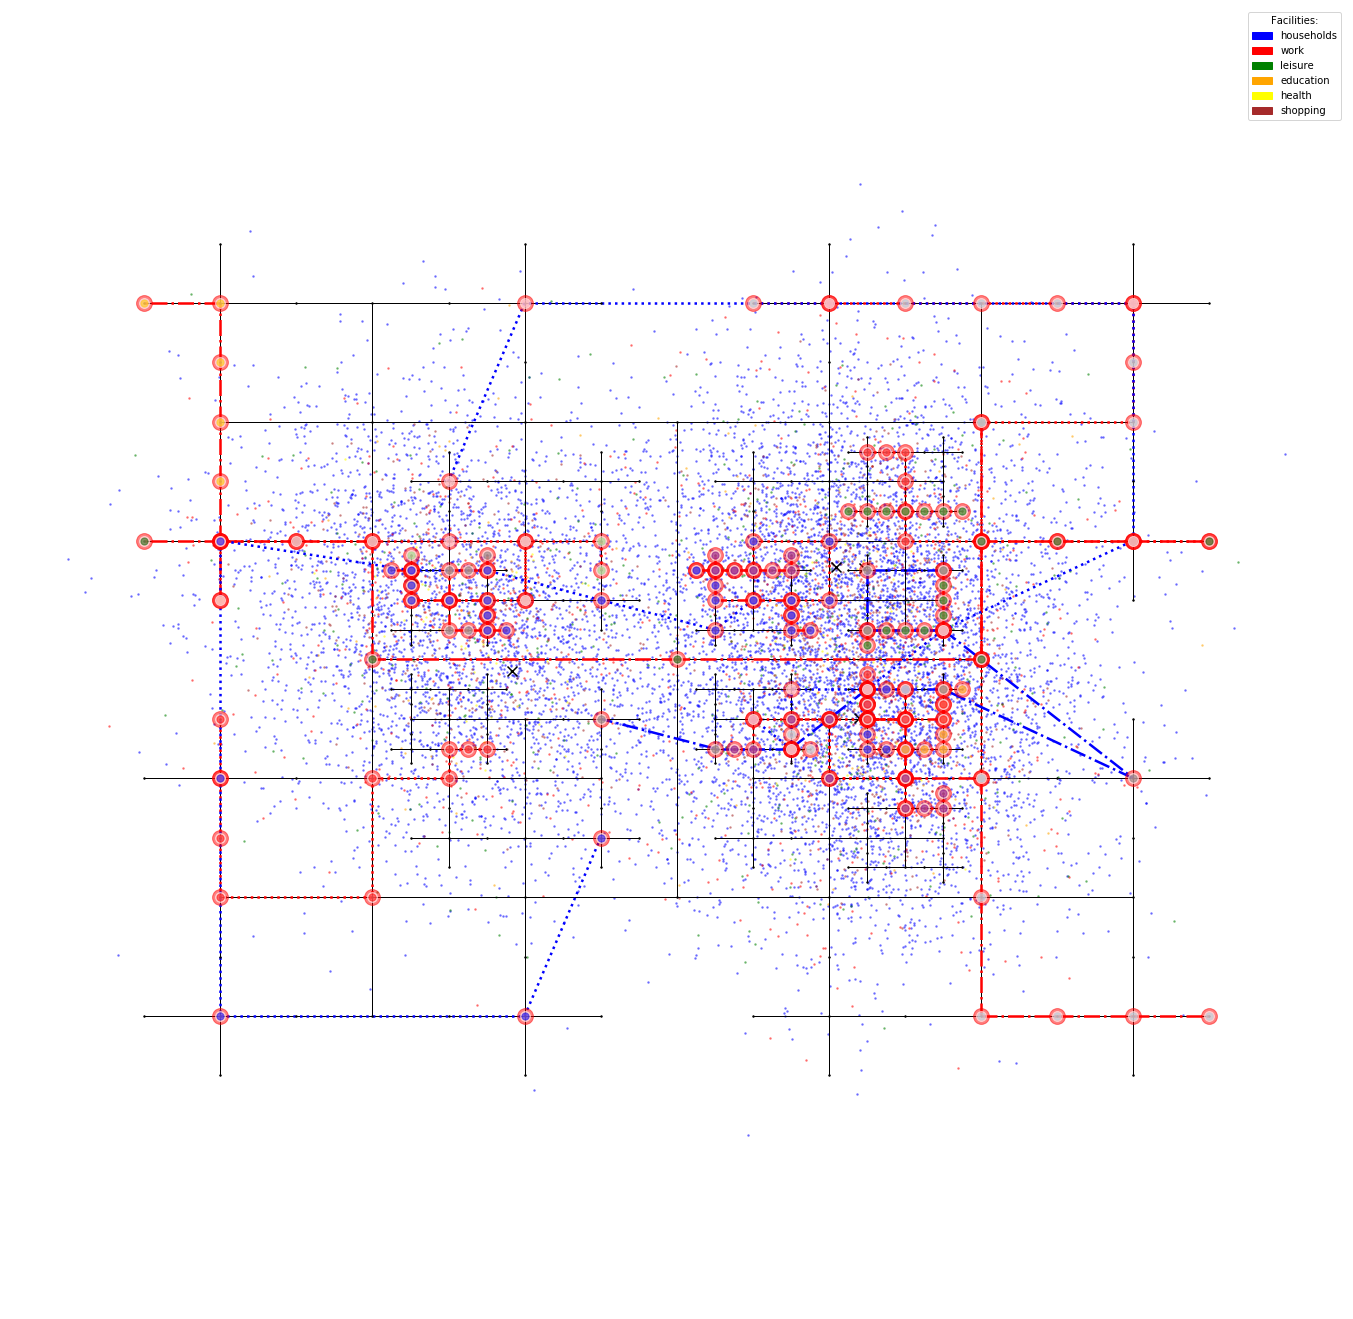

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
spatial.plot_facilities(facilities, centres=centres, ax=ax)
car_network.plot(ax=ax)
buses.plot(ax=ax)
trains.plot(ax=ax, line_colour='blue')
fig.patch.set_visible(False)
ax.axis('off')
plt.axis('equal')

In [20]:
fig.savefig(os.path.join(city_dir, 'city.png'))

### Population Features

Features for our population will be generated at two primary levels - household and individual. Additional features will be generated at both levels but be considered hidden, ie part of the generative process only.

Features will be either categorical or numeric.

We will start with household features before expanding these to the individual level based on occupants of each household.

In [21]:
hh_df = pd.DataFrame(range(facilities['households'].size), columns=['hh_index'])
hh_hidden_df = pd.DataFrame(range(facilities['households'].size), columns=['hh_index'])

### Household Zones

Generate zone geometries and assign households zone IDs.

#### Method

1. Assign index to household locations
2. Build an irregular (randomly) quad tree structure with a maximum grid density of N households
3. Assign zone to households

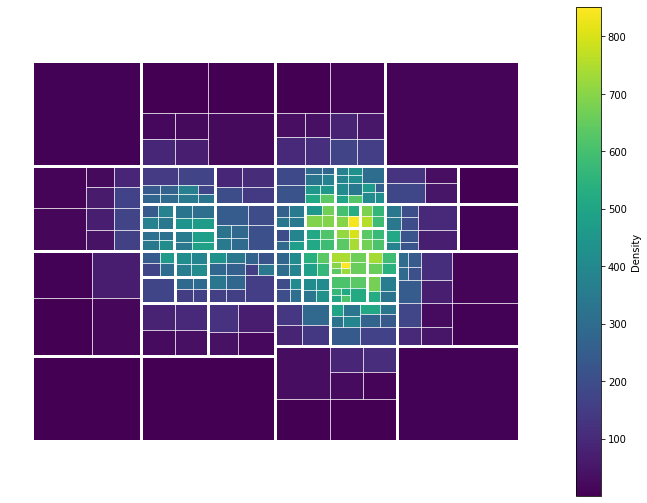

In [22]:
zones = tree.Zones(
    bbox=bbox, 
    facilities=facilities['households'],
    max_zone_facilities=500,
    max_sub_zone_facilities=100,
)
zones.plot()

In [23]:
fig.savefig(os.path.join(city_dir, 'density.png'))

In [24]:
hh_df['area_id'] = zones.facility_zone_ids
hh_df['zone_id'] = zones.facility_sub_zone_ids

In [25]:
zones.zone_gdf.to_file(os.path.join(city_dir, "zones.shp"))
zones.sub_zone_gdf.to_file(os.path.join(city_dir, "sub_zones.shp"))

### Household Hidden Features

Household hidden features will primarilly be based on spatial patterns such as facility density (based on radius R), and facility distances to nearest N facilities.

In [26]:
from citychef.household import minmax

In [27]:
hhs = facilities['households']
work = facilities['work']
leisure = facilities['leisure']
education = facilities['education']
health = facilities['health']
shopping = facilities['shopping']

hh_dist_to_centre = hhs.dist_to_centres()
hh_dist_to_centre_mm = minmax(hh_dist_to_centre)

hh_hidden_df['density_mm'] = spatial.density(hhs, hhs)
hh_hidden_df['dist_closest_centre_mm'] = spatial.distances_to_closest(hhs, centres, 1)
hh_hidden_df['dist_closest_centres_mm'] = spatial.distances_to_closest(hhs, centres, 3)
hh_hidden_df['density_work_places_mm'] = spatial.density(hhs, work, 5)
hh_hidden_df['density_leisure_mm'] = spatial.density(hhs, leisure, 5)
hh_hidden_df['dist_closest_schools_mm'] = spatial.distances_to_closest(hhs, education, 2)
hh_hidden_df['dist_closest_health_mm'] = spatial.density(hhs, health, 1)

hh_locs_mm = minmax(hhs.locs)
hh_centre_ids_mm = minmax(hhs.ids)

hh_hidden_df['hidden'] = hh.gen_hidden(hh_locs_mm[:,0], hh_locs_mm[:,1], hh_hidden_df['density_mm'])

In [28]:
hh_hidden_df.head()

,hh_index,density_mm,dist_closest_centre_mm,dist_closest_centres_mm,density_work_places_mm,density_leisure_mm,dist_closest_schools_mm,dist_closest_health_mm,hidden
0,0,0.866699,0.133641,0.058749,0.974201,0.972705,0.120232,0.744681,1
1,1,0.961983,0.096893,0.040964,0.948403,0.940447,0.058173,0.957447,3
2,2,0.912897,0.153347,0.060993,0.961916,0.965261,0.038642,0.808511,1
3,3,0.654957,0.260186,0.144399,0.813268,0.799007,0.214890,0.340426,1
4,4,0.573628,0.168363,0.140609,0.931204,0.900744,0.205553,0.446809,5


### Household Features

Household features are generated based on hidden features and previously generated features. All generative funtions combine some level of probabalitic sampling. Data sampling is designed to generate non linear and complex dependancies. The aim of which is to create a population with complex and noisy interdependencies between features.

In [29]:
hh_df['hh_count'] = hh.gen_hh_count(
    hh_hidden_df['hidden'], 
    hh_hidden_df['density_mm']
)

hh_df['hh_children'] = hh.gen_num_children(
    hh_df['hh_count'],
    hh_hidden_df['hidden'],
    hh_hidden_df['dist_closest_schools_mm'],
    hh_hidden_df['density_leisure_mm']
)

hh_hidden_df['age_group'] = hh.gen_age_group(
    hh_df['hh_children'],
    hh_hidden_df['hidden'],
    hh_hidden_df['density_mm']
)

hh_df['hh_people_in_work'] = hh.get_people_in_work(
    hh_hidden_df['age_group'],
    hh_hidden_df['hidden'],
    hh_df['hh_count'],
    hh_df['hh_children'],
    hh_hidden_df['density_mm']
)

hh_df['hh_in_work'] = hh.get_in_work(
    hh_df['hh_people_in_work']
)

hh_df['hh_income'] = hh.get_income(
    hh_df['hh_in_work'],
    hh_df['hh_count'],
    hh_df['hh_children'],
    hh_hidden_df['density_work_places_mm'],
    hh_hidden_df['density_mm']
)

hh_income_mm = minmax(hh_df['hh_income'])

hh_df['hh_cars'] = hh.get_cars(
    hh_hidden_df['hidden'],
    hh_income_mm,
    hh_hidden_df['density_mm'],
    hh_df['hh_count'],
    hh_df['hh_children']
)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

### Individual Features

Individuals features are generated based on their household hidden features and previously generated features. As per for households, all generative funtions combine some level of probabalitic sampling. Data sampling is designed to generate non linear and complex dependancies. The aim of which is to create a population with complex and noisy interdependencies between features.

In [30]:
# hh features
hh_counts = hh_df['hh_count'].to_numpy()
agent_hh_array = np.repeat(hh_df.to_numpy(), hh_counts, axis=0)
person_df = pd.DataFrame(agent_hh_array)
person_df.columns = hh_df.columns
person_df['p_hh_index'] = np.array([i for c in hh_df['hh_count'] for i in range(c)])

#hidden vectors
agent_hidden_array = np.repeat(hh_hidden_df.to_numpy(), hh_counts, axis=0)
person_hidden_df = pd.DataFrame(agent_hidden_array)
person_hidden_df.columns = hh_hidden_df.columns
person_hidden_df['p_hh_index'] = np.array([i for c in hh_df['hh_count'] for i in range(c)])

In [31]:
person_df['adult'] = person.get_is_adult(
    person_df['p_hh_index'],
    person_df['hh_count'],
    person_df['hh_children']
)

person_df['gender'] = person.get_gender(
    person_df['p_hh_index'], 
    person_df['adult'],
    person_df['hh_children'],
    person_hidden_df['hidden']
)

person_df['age'] = person.get_age(
    person_hidden_df['hidden'],
    person_hidden_df['age_group'],
    person_df['adult']
)

person_df['employment'] = person.employment(
    person_df['adult'],
    person_df['hh_people_in_work'],
    person_df['p_hh_index'],
    person_df['age'],
    person_hidden_df['hidden'],
    person_hidden_df['dist_closest_schools_mm'],
    person_hidden_df['density_work_places_mm'],
    person_df['hh_income'],
    person_hidden_df['density_mm'],
)

person_df['occupation'] = person.occupation(
    person_df['employment'],
    person_df['age'],
    minmax(person_df['hh_income']),
)

person_df.head(10)

,hh_index,area_id,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars,p_hh_index,adult,gender,age,employment,occupation
0,0.0,23.0,23.2,4.0,1.0,3.0,1.0,130000.0,1.0,0,1,0,22.0,3,1
1,0.0,23.0,23.2,4.0,1.0,3.0,1.0,130000.0,1.0,1,1,0,23.0,3,1
2,0.0,23.0,23.2,4.0,1.0,3.0,1.0,130000.0,1.0,2,1,1,22.0,3,1
3,0.0,23.0,23.2,4.0,1.0,3.0,1.0,130000.0,1.0,3,0,2,12.0,2,0
4,1.0,43.0,43.4,2.0,0.0,2.0,1.0,50000.0,1.0,0,1,1,33.0,3,1
5,1.0,43.0,43.4,2.0,0.0,2.0,1.0,50000.0,1.0,1,1,0,34.0,3,2
6,2.0,23.0,23.3,3.0,1.0,1.0,1.0,105000.0,1.0,0,1,1,22.0,3,1
7,2.0,23.0,23.3,3.0,1.0,1.0,1.0,105000.0,1.0,1,1,0,22.0,3,1
8,2.0,23.0,23.3,3.0,1.0,1.0,1.0,105000.0,1.0,2,0,1,8.0,2,0
9,3.0,32.0,32.0,2.0,0.0,2.0,1.0,75000.0,0.0,0,1,1,49.0,3,1


In [32]:
person_hidden_df.head()

,hh_index,density_mm,dist_closest_centre_mm,dist_closest_centres_mm,density_work_places_mm,density_leisure_mm,dist_closest_schools_mm,dist_closest_health_mm,hidden,age_group,p_hh_index
0,0.0,0.866699,0.133641,0.058749,0.974201,0.972705,0.120232,0.744681,1.0,19.0,0
1,0.0,0.866699,0.133641,0.058749,0.974201,0.972705,0.120232,0.744681,1.0,19.0,1
2,0.0,0.866699,0.133641,0.058749,0.974201,0.972705,0.120232,0.744681,1.0,19.0,2
3,0.0,0.866699,0.133641,0.058749,0.974201,0.972705,0.120232,0.744681,1.0,19.0,3
4,1.0,0.961983,0.096893,0.040964,0.948403,0.940447,0.058173,0.957447,3.0,31.0,0


### Activity Choice

A simple activity plan is generated based on individual features. This plan consists of a single activity at a given facility location.

#### Method
1. Activity type choice is made based on household and individual features. This can include staying at home.
2. Facilities for each activity type are weighted by their desirability (based on density and distance).
3. Agents randomly choose a facility based on this weighting and on their individual features.

In [33]:
# Main activity choice
person_df['main_activity'] = choice.main_activity_choice(
    person_df['employment'],
    person_hidden_df['density_work_places_mm'],
    person_df['occupation'],
    person_hidden_df['hidden'],
    minmax(person_df['hh_income']),
    person_df['hh_count'],
    person_hidden_df['dist_closest_centres_mm'],
    person_hidden_df['density_leisure_mm'],
    person_df['age'],
)

In [34]:
# FACILITY FEATURES
zone_gdf = zones.sub_zone_gdf

work_df = pd.DataFrame(range(work.size), columns=['index'])
work_df['density_mm'] = spatial.density(work, work, r=.5)
work_df['geometry'] = [Point(x,y) for x,y in work.locs]
work_gdf = gpd.GeoDataFrame(work_df, geometry='geometry')
work_gdf = gpd.sjoin(work_gdf, zone_gdf, how="left", op='within').drop('index_right', axis=1)

leisure_df = pd.DataFrame(range(leisure.size), columns=['index'])
leisure_df['density_mm'] = spatial.density(leisure, shopping, r=1)
leisure_df['geometry'] = [Point(x,y) for x,y in leisure.locs]
leisure_gdf = gpd.GeoDataFrame(leisure_df, geometry='geometry')
leisure_gdf = gpd.sjoin(leisure_gdf, zone_gdf, how="left", op='within').drop('index_right', axis=1)

education_df = pd.DataFrame(range(education.size), columns=['index'])
education_df['density_mm'] = spatial.density(education, shopping, r=2)
education_df['geometry'] = [Point(x,y) for x,y in education.locs]
education_gdf = gpd.GeoDataFrame(education_df, geometry='geometry')
education_gdf = gpd.sjoin(education_gdf, zone_gdf, how="left", op='within').drop('index_right', axis=1)

health_df = pd.DataFrame(range(health.size), columns=['index'])
health_df['density_mm'] = spatial.density(health, shopping, r=2)
health_df['geometry'] = [Point(x,y) for x,y in health.locs]
health_gdf = gpd.GeoDataFrame(health_df, geometry='geometry')
health_gdf = gpd.sjoin(health_gdf, zone_gdf, how="left", op='within').drop('index_right', axis=1)

shopping_df = pd.DataFrame(range(shopping.size), columns=['index'])
shopping_df['density_mm'] = spatial.density(shopping, shopping, r=.3)
shopping_df['geometry'] = [Point(x,y) for x,y in shopping.locs]
shopping_gdf = gpd.GeoDataFrame(shopping_df, geometry='geometry')
shopping_gdf = gpd.sjoin(shopping_gdf, zone_gdf, how="left", op='within').drop('index_right', axis=1)


(-3.8888999573766254, 8.953817468061665, -4.035499430262596, 5.994019199702548)

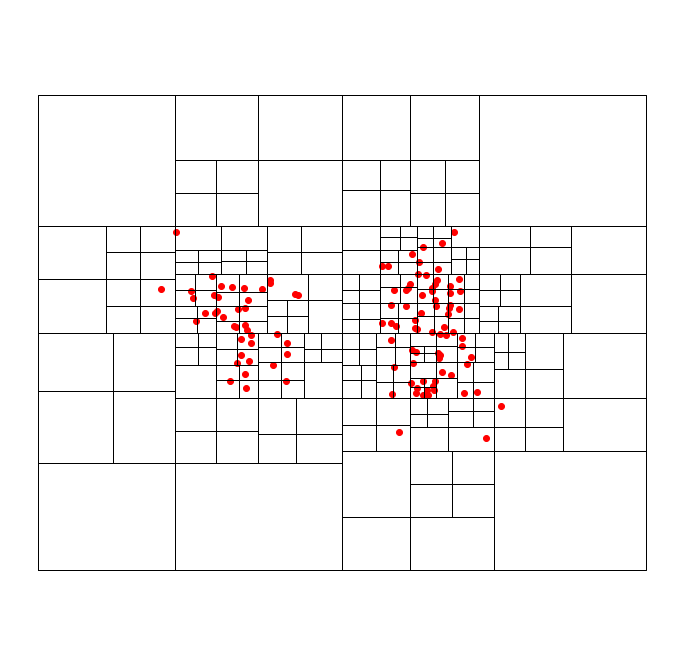

In [35]:
# check that this has worked ok...

fig, ax = plt.subplots(figsize=(12,12))

zone_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax)

health_gdf.plot(ax=ax, c='r')

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('equal')

In [36]:
hhs_work_distances = minmax(cdist(hhs.locs, work.locs))
hhs_education_distances = minmax(cdist(hhs.locs, education.locs))
hhs_shopping_distances = minmax(cdist(hhs.locs, shopping.locs))
hhs_leisure_distances = minmax(cdist(hhs.locs, leisure.locs))
hhs_health_distances = minmax(cdist(hhs.locs, health.locs))

In [37]:
main_facility_id = np.zeros((len(person_df)))
main_facility_area = np.zeros((len(person_df)))
main_facility_zone = np.zeros((len(person_df)))

for i, (hh_index, main_act, income_mm) in enumerate(zip(person_df.hh_index, person_df.main_activity, minmax(person_df['hh_income']))):
    
    if main_act == 0:  # home
        main_facility_id[i] = -1
        main_facility_area[i] = -1
        main_facility_zone[i] = -1
        
    hh_index = int(hh_index)
        
    if main_act == 1:  # work
        facility_distances = hhs_work_distances[hh_index]
        facility_scores = (1 - income_mm) * (1 - facility_distances) + income_mm * work_df.density_mm
        facility_scores = facility_scores / facility_scores.sum()
        facitlity_id = np.random.choice(range(len(facility_scores)), p=facility_scores)
        main_facility_id[i] = facitlity_id
        main_facility_area[i], main_facility_zone[i] = work_gdf[['area_id', 'zone_id']].iloc[facitlity_id]
        continue
        
    if main_act == 2:  # education
        facility_distances = hhs_education_distances[hh_index]
        facility_scores = (1 - facility_distances) ** 2
        facility_scores = facility_scores / facility_scores.sum()
        facitlity_id = np.random.choice(range(len(facility_scores)), p=facility_scores)
        main_facility_id[i] = facitlity_id
        main_facility_area[i], main_facility_zone[i] = education_gdf[['area_id', 'zone_id']].iloc[facitlity_id]
        continue
        
    if main_act == 3:  # shopping
        facility_distances = hhs_shopping_distances[hh_index]
        facility_scores = (1 - income_mm) * (1 - facility_distances) + income_mm * shopping_df.density_mm
        facility_scores = facility_scores / facility_scores.sum()
        facitlity_id = np.random.choice(range(len(facility_scores)), p=facility_scores)
        main_facility_id[i] = facitlity_id
        main_facility_area[i], main_facility_zone[i] = shopping_gdf[['area_id', 'zone_id']].iloc[facitlity_id]
        continue
        
    if main_act == 4:  # leisure
        facility_distances = hhs_leisure_distances[hh_index]
        facility_scores = (1 - facility_distances)
        facility_scores = facility_scores / facility_scores.sum()
        facitlity_id = np.random.choice(range(len(facility_scores)), p=facility_scores)
        main_facility_id[i] = facitlity_id
        main_facility_area[i], main_facility_zone[i] = leisure_gdf[['area_id', 'zone_id']].iloc[facitlity_id]
        continue
        
    if main_act == 5:  # health
        facility_distances = hhs_health_distances[hh_index]
        facility_scores = (1 - facility_distances) ** 4
        facility_scores = facility_scores / facility_scores.sum()
        facitlity_id = np.random.choice(range(len(facility_scores)), p=facility_scores)
        main_facility_id[i] = facitlity_id
        main_facility_area[i], main_facility_zone[i] = health_gdf[['area_id', 'zone_id']].iloc[facitlity_id]
        continue

person_df['main_activity_id'] = main_facility_id
person_df['main_facility_area'] = main_facility_area
person_df['main_facility_zone'] = main_facility_zone


### Mode Choice

Individuals choose a mode of transport (car, public transit, bike or walk) based on the expected journey time and their individual features.

#### Method
Journey time prediction for the network modes (car and public transit) are comprised of three parts:
1. Estimated journey time from household to nearest network node.
2. Estimated journey time from household nearest network node to facility nearest network node.
3. Estimated journey time from facility nearest network node to facility.

In [38]:
# HH CAR CONNECTIVITY
car_ods = graph.NodesOD(car_network.g)

hh_df['car_dist'], hh_df['car_node'] = spatial.distance_index_nearest_node(hhs, car_network.locs)
work_df['car_dist'], work_df['car_node'] = spatial.distance_index_nearest_node(work, car_network.locs)
leisure_df['car_dist'], leisure_df['car_node'] = spatial.distance_index_nearest_node(leisure, car_network.locs)
education_df['car_dist'], education_df['car_node'] = spatial.distance_index_nearest_node(education, car_network.locs)
health_df['car_dist'], health_df['car_node'] = spatial.distance_index_nearest_node(health, car_network.locs)
shopping_df['car_dist'], shopping_df['car_node'] = spatial.distance_index_nearest_node(shopping, car_network.locs)

In [39]:
# HH PT CONNECTIVITY
pt_network = nx.compose(total_bus_graph, total_train_graph)
pt_pos = {n:d['pos'] for n,d in pt_network.nodes(data=True)}
pt_node_locs = np.array([d['pos'] for n,d in pt_network.nodes(data=True)])
pt_ods = graph.NodesOD(pt_network)

In [40]:
hh_df['pt_dist'], hh_df['pt_node'] = spatial.distance_index_nearest_node(hhs, pt_node_locs)
work_df['pt_dist'], work_df['pt_node'] = spatial.distance_index_nearest_node(work, pt_node_locs)
leisure_df['pt_dist'], leisure_df['pt_node'] = spatial.distance_index_nearest_node(leisure, pt_node_locs)
education_df['pt_dist'], education_df['pt_node'] = spatial.distance_index_nearest_node(education, pt_node_locs)
health_df['pt_dist'], health_df['pt_node'] = spatial.distance_index_nearest_node(health, pt_node_locs)
shopping_df['pt_dist'], shopping_df['pt_node'] = spatial.distance_index_nearest_node(shopping, pt_node_locs)

In [41]:
car_time = np.zeros((len(person_df)))
pt_time = np.zeros((len(person_df)))
cycle_time = np.zeros((len(person_df)))
walk_time = np.zeros((len(person_df)))
mode_choice = np.zeros((len(person_df)))
journey_time = np.zeros((len(person_df)))

for i, (hh_index, main_act, main_id, income_mm, age_mm, adult, children, cars) in enumerate(
    zip(
        person_df.hh_index,
        person_df.main_activity,
        person_df.main_activity_id,
        minmax(person_df.hh_income),
        minmax(person_df.age),
        person_df.adult,
        person_df.hh_children,
        person_df.hh_cars,
              )):
    
    if main_act == 0:  # home
        mode_choice[i] = -1
        continue
        
    main_id = int(main_id)
    hh_index = int(hh_index)
    
    hh_loc = hhs.locs[hh_index]
    
    hh_car_node_dist, hh_car_node = hh_df.car_dist[hh_index], hh_df.car_node[hh_index]
    hh_car_node_time = 1.4 * 3600 * hh_car_node_dist / 25
    
    hh_pt_node_dist, hh_pt_node = hh_df.pt_dist[hh_index], hh_df.pt_node[hh_index]
    hh_pt_node_time = 3600 * hh_car_node_dist / 5
    
    times = {}
    options = {}
        
    if main_act == 1:  # work
        
        facility_loc = work.locs[main_id]
        facility_df = work_df
        
    if main_act == 2:  # education
        
        facility_loc = education.locs[main_id]
        facility_df = education_df
        
    if main_act == 3:  # shopping
        
        facility_loc = shopping.locs[main_id]
        facility_df = shopping_df
        
    if main_act == 4:  # leisure
        
        facility_loc = leisure.locs[main_id]
        facility_df = leisure_df
        
    if main_act == 5:  # health
        
        facility_loc = health.locs[main_id]
        facility_df = health_df
     
    # choice
    eucl_distance = ((hh_loc - facility_loc)**2).sum()**.5
    manh_distance = np.abs(hh_loc - facility_loc).sum()
    
    # car
    facility_car_node_dist, facility_car_node = facility_df.car_dist[main_id], facility_df.car_node[main_id]
    car_network_travel = car_ods.get(hh_car_node, facility_car_node)
    if car_network_travel != -1:
        facility_car_node_time = 1.4 * 3600 * facility_car_node_dist / 25
        car_journey_time = hh_car_node_time + facility_car_node_time + car_network_travel + 300
        if car_journey_time > 300:
            car_time[i] = car_journey_time
            times[0] = car_journey_time

            if not cars:
                options[0] = car_journey_time * 3
            else:
                options[0] = car_journey_time * (1.1 - cars / 10) * (1 - children / 10)
    
    # pt
    facility_pt_node_dist, facility_pt_node = facility_df.pt_dist[main_id], facility_df.pt_node[main_id]
    pt_network_travel = pt_ods.get(hh_pt_node, facility_pt_node)
    if pt_network_travel != -1:
        facility_pt_node_time = 3600 * facility_pt_node_dist / 5
        pt_journey_time = hh_pt_node_time + facility_pt_node_time + pt_network_travel + 120
        if pt_journey_time > 300:
            pt_time[i] = pt_journey_time
            times[1] = pt_journey_time

            options[1] = pt_journey_time * (1 + age_mm / 100) * (1 + income_mm / 10)
    
    # cycle
    cycle_journey_time = 360 * manh_distance / 15 + 120
    if (cycle_journey_time < 3600) and (cycle_journey_time > 120):
        cycle_time[i] = cycle_journey_time
        times[2] = cycle_journey_time
        
        if main_act == 3:
            options[2] = cycle_journey_time * 3
        else:
            options[2] = cycle_journey_time * (1 + age_mm / 10) * (1 + income_mm / 10)

    # walk
    walk_journey_time = 360 * eucl_distance / 5
    if walk_journey_time < 3600:
        walk_time[i] = walk_journey_time
        times[3] = walk_journey_time
        options[3] = walk_journey_time
    
    weights = np.array(list(options.values()))
    weights = weights / weights.sum()
    mode = np.random.choice(list(options), p=weights)
    time = times[mode]
    
    mode_choice[i] = mode
    journey_time[i] = time


In [42]:
person_df['mode'] = mode_choice
person_hidden_df['journey_time'] = journey_time

### Data Outputs

We produce various aggregated and sampled outputs in the style of typically available data sources:
1. census marginals
2. census commuter surveys
3. household travel surveys

Where census denotes a fully representative sample, ie of the whole population.

Additionally we output a full record of all persons data (ie a census of household travel surveys). This level is generally not known for an entire population, so should be treated as the test dataset in most synthesis experiments.

In [43]:
header = {
    'hh_in_work': {
        0: 'no one currently in work',
        1: 'one or more persons in work',
    },
    'adult': {
        0: 'person under 16',
        1: 'person 16 or over',
    },
    'gender': {
        0: 'male',
        1: 'female',
        2: 'other/unknown/not declared',
    },
    'employment': {
        0: 'retired',
        1: 'unemployed',
        2: 'education',
        3: 'employment',
    },
    'occupation': {
        0: 'none',
        1: 'unskilled',
        2: 'slkilled',
        3: 'manager',
    },
    'main_activity': {
        0: 'home (ill, wfh)',
        1: 'work',
        2: 'education',
        3: 'shopping',
        4: 'leisure',
        5: 'health',
    },
    'mode': {
        0: 'car',
        1: 'PT',
        2: 'cycle',
        3: 'walk',
    },
    'hh_income_bin': {
        0: 'lower quartile, - 35k',
        1: 'lower-middle quartile, 35-55k',
        2: 'upper-middle quartile, 55-90k',
        3: 'upper quartile, 90k +',
    },
    'age_bin': {
        0: '-4',
        4: '4-13',
        13: '13-16',
        16: '16-21',
        21: '21-31',
        31: '31-41',
        41: '41-51',
        51: '51-61',
        61: '61-71',
        71: '71-81',
        81: '81+',
    }
}

In [44]:
import json
with open('city_zero/header.json', 'w') as f:
    json.dump(header, f)

In [45]:
# bin the continuous variables (income and age)
d = person_df.hh_income.describe()
bins = [0, d['25%'], d['50%'], d['75%'], d['max']]
print(bins)
labels = [0,1,2,3]
person_df['hh_income_bin'] = pd.cut(person_df.hh_income, bins=bins, labels=labels)

bins = [-1, 4, 13, 16, 21, 31, 41, 51, 61, 71, 81, 120]
labels = ['0-4', '4-13', '13-16','16-21', '21-31', '31-41', '41-51', '51-61', '61-71', '71-81', '81+']
labels = [0, 4, 13, 16, 21, 31, 41, 51, 61, 71, 81]
person_df['age_bin'] = pd.cut(person_df.age, bins=bins, labels=labels)

person_df.head()

[0, 50000.0, 90000.0, 135000.0, 350000.0]


,hh_index,area_id,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars,p_hh_index,...,age,employment,occupation,main_activity,main_activity_id,main_facility_area,main_facility_zone,mode,hh_income_bin,age_bin
0,0.0,23.0,23.2,4.0,1.0,3.0,1.0,130000.0,1.0,0,...,22.0,3,1,1,923.0,44.0,44.0,0.0,2,21
1,0.0,23.0,23.2,4.0,1.0,3.0,1.0,130000.0,1.0,1,...,23.0,3,1,1,35.0,30.0,30.6,2.0,2,21
2,0.0,23.0,23.2,4.0,1.0,3.0,1.0,130000.0,1.0,2,...,22.0,3,1,1,998.0,23.0,23.2,0.0,2,21
3,0.0,23.0,23.2,4.0,1.0,3.0,1.0,130000.0,1.0,3,...,12.0,2,0,2,14.0,45.0,45.2,0.0,2,4
4,1.0,43.0,43.4,2.0,0.0,2.0,1.0,50000.0,1.0,0,...,33.0,3,1,1,754.0,45.0,45.3,0.0,0,31


#### Census Marginal Statistics

In [46]:
# area marginals
marginal_headers = [
    'hh_count',
    'hh_children',
    'hh_in_work',
    'hh_income_bin',
    'hh_cars',
    'gender',
    'age_bin',
    'employment',
    'occupation',
    'main_activity',
    'mode',
]

# group by home area
for m in marginal_headers:
    name = 'area_marginal_' + m + '.csv'
    print(name)
    marginal_df = person_df[m].groupby([person_df.area_id, person_df[m]]).count()
    marginal_df.columns = ['area', m, 'freq']
    marginal_df.to_csv(os.path.join(city_dir, name), header=True)

area_marginal_hh_count.csv
area_marginal_hh_children.csv
area_marginal_hh_in_work.csv
area_marginal_hh_income_bin.csv
area_marginal_hh_cars.csv
area_marginal_gender.csv
area_marginal_age_bin.csv
area_marginal_employment.csv
area_marginal_occupation.csv
area_marginal_main_activity.csv
area_marginal_mode.csv


#### Commuter Survey Output

We extract tours for work and education activities and create an zone based origin - destination freq table.

Note that we could further break-down by activity type and or mode choice.

In [47]:
activities = [1,2] # work & education
commuter_df = person_df.hh_index.loc[person_df.main_activity.isin(activities)]
commuter_freq_df = commuter_df.groupby([person_df.zone_id, person_df.main_facility_zone]).count()
assert len(commuter_df) == sum(commuter_freq_df)
commuter_freq_df.name = 'freq'
commuter_freq_df.to_csv(os.path.join(city_dir, 'zone_commuter_freq_table.csv'), header=True)

In [48]:
# matrix version
commuter_freq_df.unstack().to_csv(os.path.join(city_dir, 'zone_commuter_freq_matrix.csv'), header=True)

#### Household Survey Data

We extract a sample of households from the personal attributes to represent dis-aggregate household survey data.

In [49]:
# sample
sample_size = 3000  # households
sample_hh_index = np.random.choice(person_df.hh_index.unique(), replace=False, size=sample_size)
sample_df = person_df.loc[person_df.hh_index.isin(sample_hh_index)]
sample_df.drop(['hh_income', 'age'], axis=1, inplace=True)
sample_df.to_csv(os.path.join(city_dir, 'hh_travel_diary.csv'), header=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Full Person Level Data

In [50]:
person_df.to_csv(os.path.join(city_dir, 'full_hh_survey_census.csv'), header=True)